<a href="https://colab.research.google.com/github/econ105/AI/blob/main/CourseHousingPriceForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# Step 1: Install the required libraries
!pip install pandas openpyxl
from google.colab import files
uploaded = files.upload()

Saving HousePricePrediction.xlsx to HousePricePrediction (2).xlsx


# New Section

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_excel("/content/HousePricePrediction.xlsx")

# Printing first 5 records of the dataset
print(dataset.head(5))

   Id  MSSubClass MSZoning  LotArea LotConfig BldgType  OverallCond  \
0   0          60       RL     8450    Inside     1Fam            5   
1   1          20       RL     9600       FR2     1Fam            8   
2   2          60       RL    11250    Inside     1Fam            5   
3   3          70       RL     9550    Corner     1Fam            5   
4   4          60       RL    14260       FR2     1Fam            5   

   YearBuilt  YearRemodAdd Exterior1st  BsmtFinSF2  TotalBsmtSF  SalePrice  
0       2003          2003     VinylSd         0.0        856.0   208500.0  
1       1976          1976     MetalSd         0.0       1262.0   181500.0  
2       2001          2002     VinylSd         0.0        920.0   223500.0  
3       1915          1970     Wd Sdng         0.0        756.0   140000.0  
4       2000          2000     VinylSd         0.0       1145.0   250000.0  


In [9]:
obj = (dataset.dtypes == 'object')#we categorize the features depending on their datatype (int, float, object) and then calculate the number of them.
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))


Categorical variables: 4
Integer variables: 6
Float variables: 3


<Axes: >

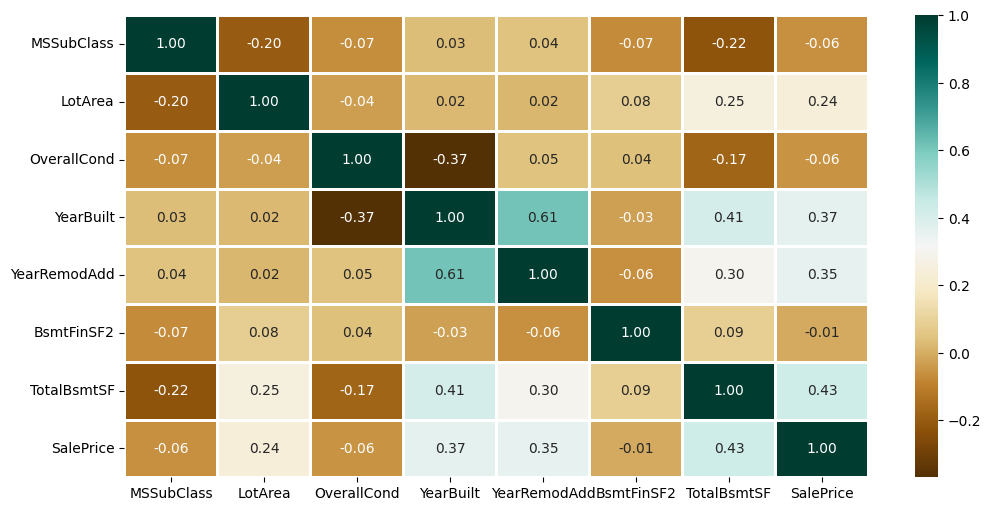

In [25]:
#Explorary data analysis refers to the deep analysis of data so as to discover
#different patterns and spot anomalies. Before making inferences from data it is essential to examine all your variables.
# Select only numerical features for correlation analysis
numerical_dataset = dataset.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))#Make a heatmap using seaborn library
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

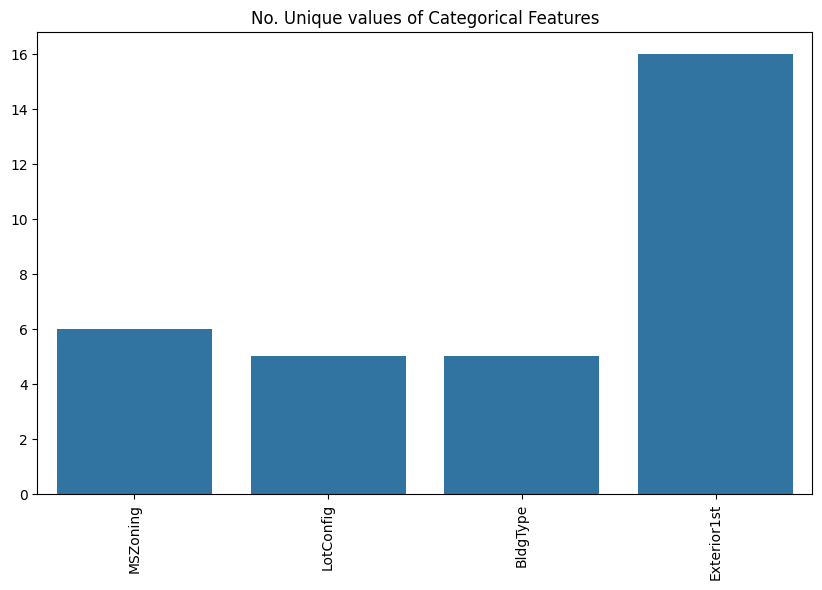

In [11]:
unique_values = []#To analyze the different categorical features. Let’s draw the barplot
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

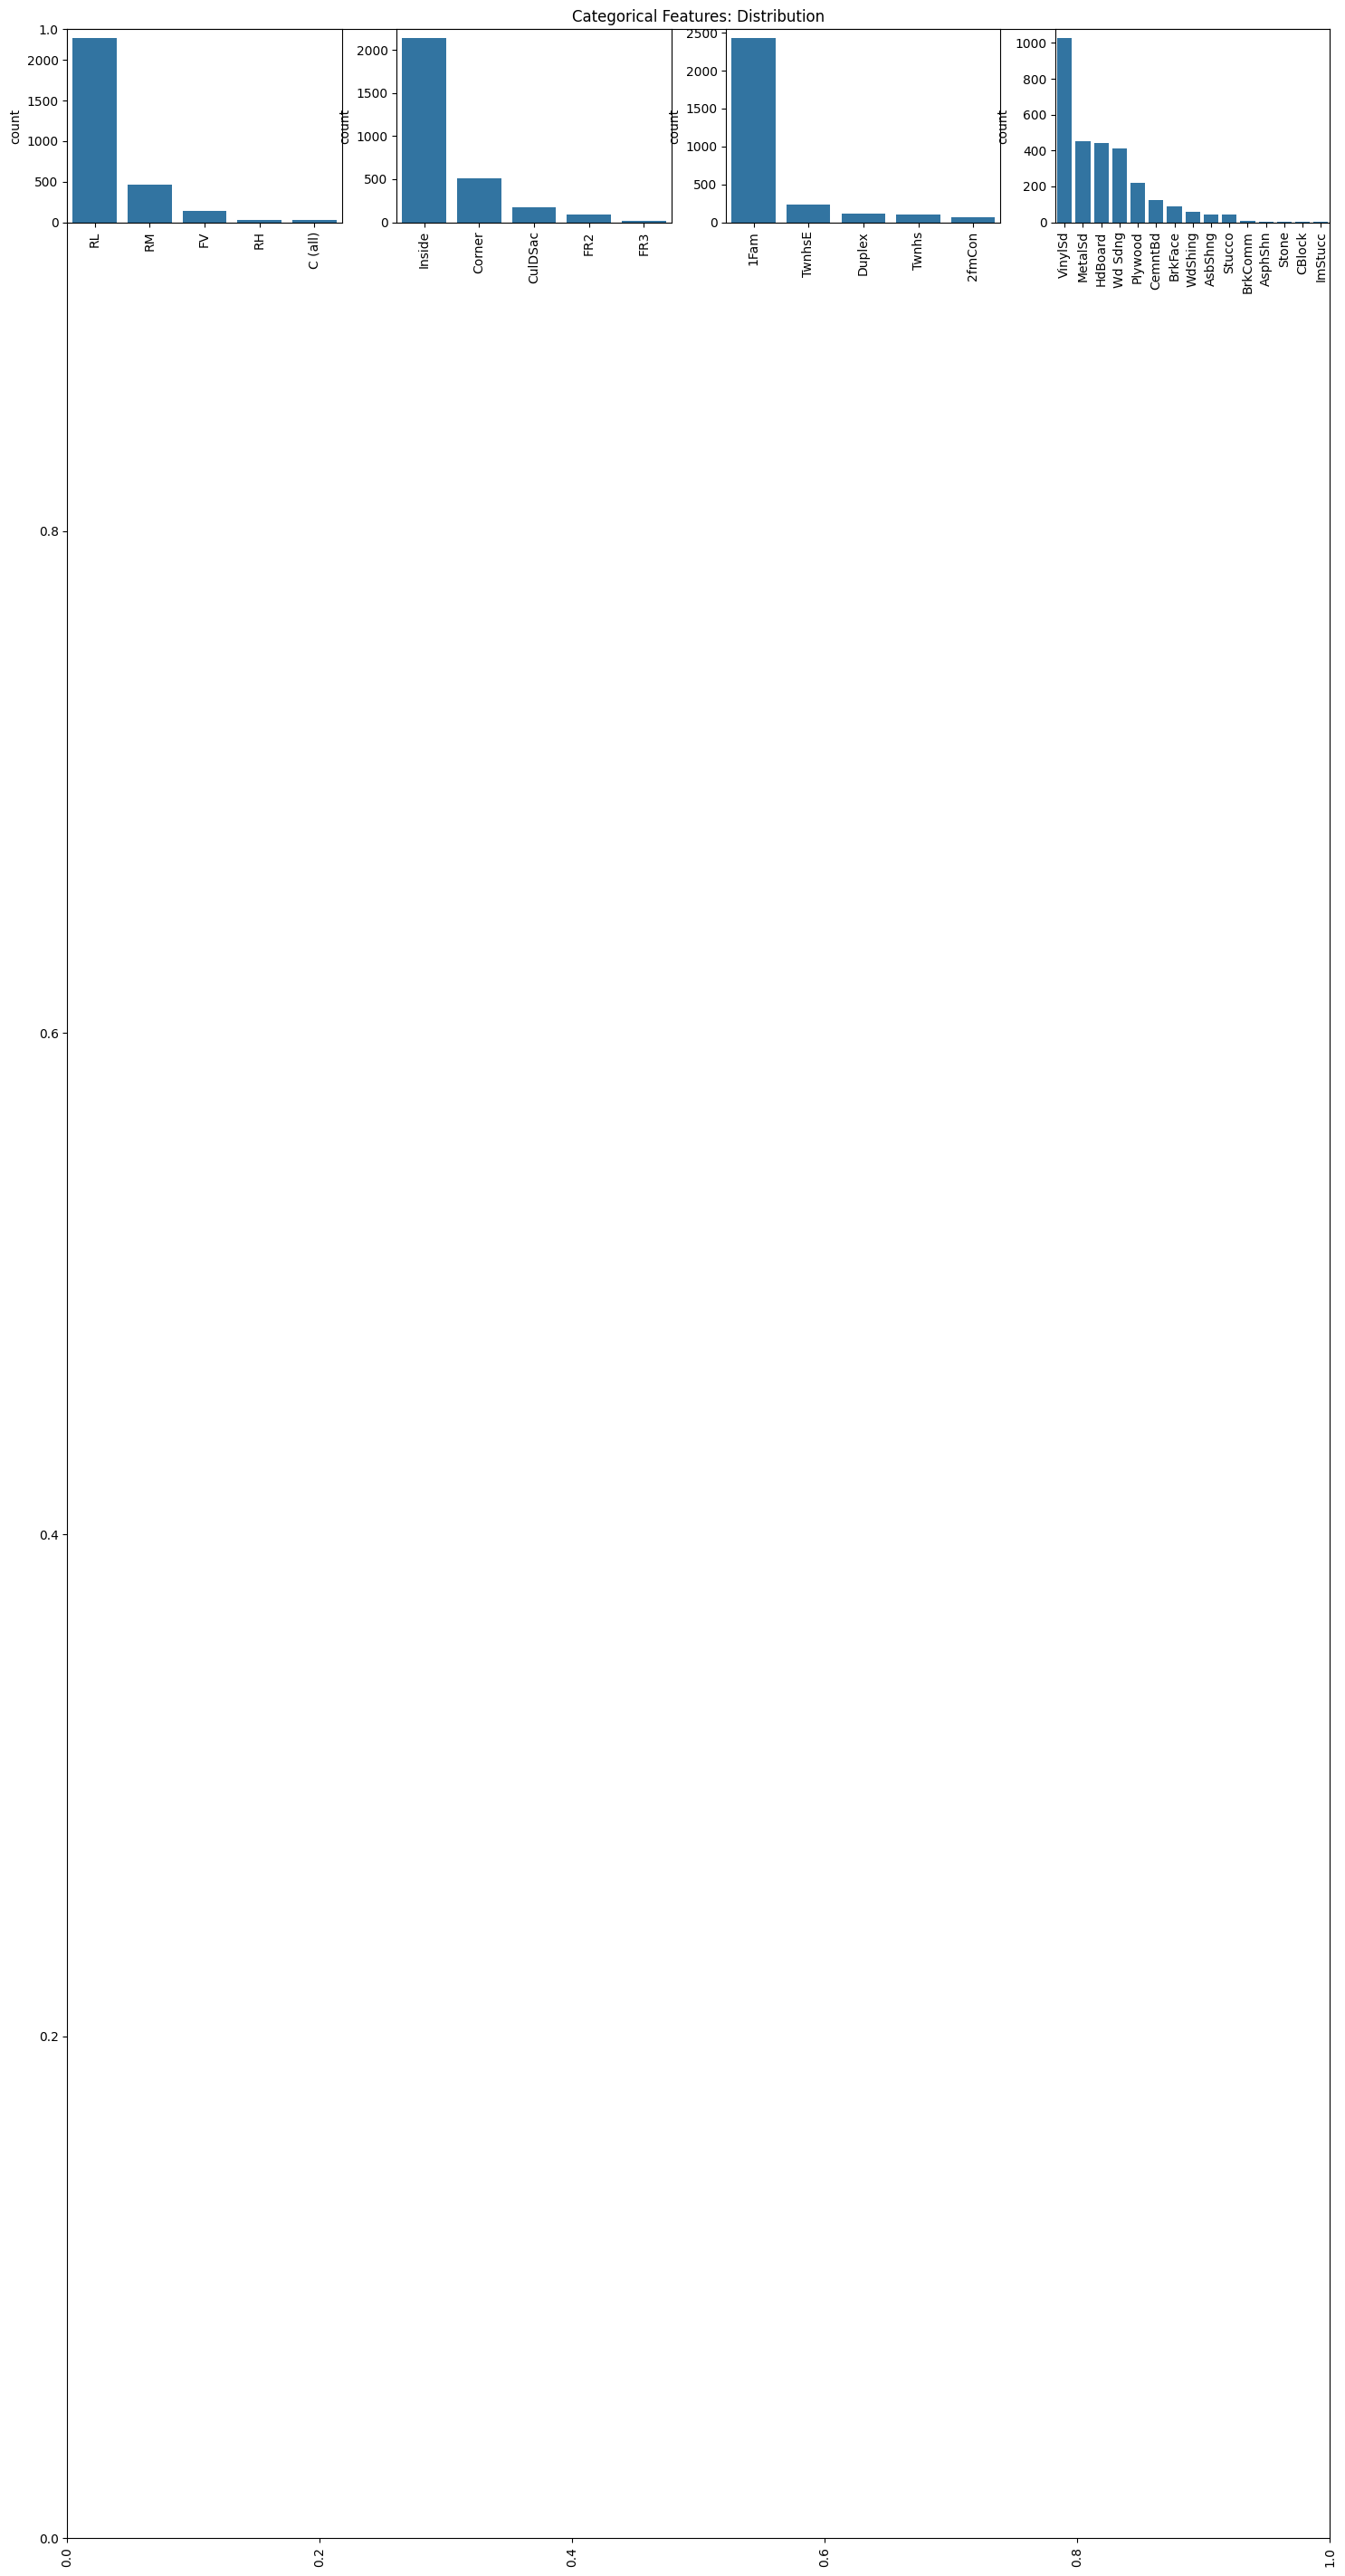

In [24]:
#The plot shows that Exterior1st has around 16 unique categories and other features have around  6 unique categories.
#To findout the actual count of each category we can plot the bargraph of each four features separately.
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [13]:
#Data Cleaning is the way to improvise the data or remove incorrect, corrupted or irrelevant data.

#As in our dataset, there are some columns that are not important and irrelevant for the model training.
#So, we can drop that column before training, like 'Id' is not our concern
dataset.drop(['Id'],
             axis=1,
             inplace=True)

In [14]:
#Replacing SalePrice empty values with their mean values to make the data distribution symmetric.
dataset['SalePrice'] = dataset['SalePrice'].fillna(
  dataset['SalePrice'].mean())

In [15]:
#Drop records with null values (as the empty records are very less).
new_dataset = dataset.dropna()

In [16]:
#Checking features which have null values in the new dataframe (if there are still any).
new_dataset.isnull().sum()

,0
MSSubClass,0
MSZoning,0
LotArea,0
LotConfig,0
BldgType,0
OverallCond,0
YearBuilt,0
YearRemodAdd,0
Exterior1st,0
BsmtFinSF2,0


In [17]:
#One hot Encoding is the best way to convert categorical data into binary vectors.
#we can easily convert object data into int. So for that, firstly we have to collect all the features which have the object datatype.
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
      len(object_cols))

Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of. categorical features:  4


In [18]:
#Then once we have a list of all the features. We can apply OneHotEncoding to the whole list
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))

OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out(object_cols)

df_final = pd.concat([new_dataset.drop(object_cols, axis=1), OH_cols], axis=1)

In [20]:
#Splitting Dataset into Training and Testing
# X and Y splitting (i.e. Y is the SalePrice column and the rest of the other columns are X)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
Y = df_final['SalePrice']

# Split the training set into
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [21]:
# Support vector Machine can be used for both regression and classification model.
#It finds the hyperplane in the n-dimensional plane
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1870512931870423


In [22]:
#Random Forest is an ensemble technique that can be used for both regression and classification tasks.
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred)

0.1889152294659003

In [23]:
#Linear Regression predicts the final output-dependent value based on the given independent features.
#Like, here we have to predict SalePrice depending on features like MSSubClass, YearBuilt, BldgType, Exterior1st etc
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1874168384159986


In [ ]:
#Conclusion
#Clearly, SVM model is giving better accuracy as the mean absolute error is the least among all the other regressor models i.e. 0.18 approx